# Final Project Notebook 7 - Word Embedding 1

## Metadata

```

MacKenzye Leroy (zuf9mc@vriginia.edu)
DS 5001
2 May 2022

Purpose:  This notebook cuses word2vec to create 
Note: Much of the code in the notebook was originally witten by Dr. Rafael Alverado and has been editted to fit my particular problem 
```

# Set Up

In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
from scipy.linalg import norm

In [2]:
import plotly.express as px
import seaborn as sns; sns.set()
import os

In [3]:
norm_docs = True # L2 norming
center_by_mean = True 
n_terms = 1000 # Number of significant words; feature space
k = 6 # Number of components

In [4]:
#os.chdir('/Users/mackenzyeleroy/Documents/MSDS/DS5001/FinalProject')
home_dir = os.getcwd()
home_dir

'/Users/mackenzyeleroy/Documents/MSDS/DS5001/ETA-Final-Project/FinalProject'

In [5]:
data_home = f"{home_dir}/Data"

parser_lib = f"{home_dir}/lib"
source_files = f'{data_home}/output'
data_prefix = 'wells-verne'

In [6]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [7]:
w2v_params = dict(
    min_count = 10,
    workers = 4,
    # vector_size = 246,
    vector_size = 100,
    window = 2    
)

In [8]:
tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 40,
    n_components = 2,
    init = 'random',
    n_iter = 1000,
    random_state = 23    
)

# Get Data

In [9]:
TOKENS = pd.read_csv(f"{source_files}/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [10]:
TOKENS.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                
35      1       0        0        0          ('Introduction', 'NN')   NN   
                1        0        0                   ('The', 'DT')   DT   
                                  1                 ('Time', 'NNP')  NNP   
                                  2            ('Traveller', 'NNP')  NNP   
                                  3                 ('(for', 'NNP')  NNP   

                                                token_str      term_str  
book_id chap_id para_num sent_num token_num                              
35      1       0        0        0          Introduction  introduction  
                1        0        0                   The           the  
                                  1                  Time          time  
                                  2             Traveller     traveller  
                                  3                  (for           for

# Extract VOCAB

Use this to filter significant terms and to store w2v features and tSNE coordinates.

In [11]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'

In [12]:
VOCAB['pos_max'] = TOKENS.value_counts(['term_str','pos']).unstack().idxmax(1)

In [13]:
VOCAB['pos_group'] = VOCAB.pos_max.str.slice(0,2)

# Add Chapter Significance

In [14]:
CHAPS = TOKENS.groupby(OHCO[:2]+['term_str']).term_str.count()\
    .unstack(fill_value=0).astype('bool').astype('int')

In [15]:
CHAPS.head()

term_str         0  000436  016  05  092  0h  1  10  100  1000  ...  â  \
book_id chap_id                                                 ...      
35      1        0       0    0   0    0   0  0   0    0     0  ...  0   
        2        0       0    0   0    0   0  0   0    0     0  ...  0   
        3        0       0    0   0    0   0  0   0    0     0  ...  0   
        4        0       0    0   0    0   0  0   0    0     0  ...  0   
        5        0       0    0   0    0   0  0   0    0     0  ...  0   

term_str         âtrice  æsthetic  æstheticism  éclat  épicier  ō  œdipus  α  \
book_id chap_id                                                                
35      1             0         0            0      0        0  0       0  0   
        2             0         0            0      0        0  0       0  0   
        3             0         0            0      0        0  0       0  0   
        4             0         0            0      0        0  0       0  0   
        5             0         0            0      0        0  0       0  0   

term_str         β  
book_id chap_id     
35      1        0  
        2        0  
        3        0  
        4        0  
        5        0  

[5 rows x 40079 columns]

In [16]:
VOCAB['df'] = CHAPS.sum()
VOCAB['dfidf'] = VOCAB.df * np.log2(len(CHAPS)/VOCAB.df)

In [17]:
VOCAB.sort_values('dfidf', ascending=False)

n pos_max pos_group   df       dfidf
term_str                                           
told         431     VBD        VB  211  304.643433
friends      455      NN        NN  212  304.641132
present      428      JJ        JJ  210  304.638896
master       521      NN        NN  213  304.632026
held         355     VBD        VB  213  304.632026
...          ...     ...       ...  ...         ...
and        58699      CC        CC  574    0.000000
of         67371      IN        IN  574    0.000000
a          41252      DT        DT  574    0.000000
in         29005      IN        IN  574    0.000000
the       126415      DT        DT  574    0.000000

[40079 rows x 5 columns]

# Get List of Token Lists

Because that's what Gensim wants.

In [18]:
SENTS = TOKENS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

# Learn Word Embeddings

In [19]:
SENTS.head().tolist()

[['introduction'],
 ['the',
  'time',
  'traveller',
  'for',
  'so',
  'it',
  'will',
  'be',
  'convenient',
  'to',
  'speak',
  'of',
  'him',
  'was',
  'expounding',
  'a',
  'recondite',
  'matter',
  'to',
  'us'],
 ['his',
  'pale',
  'grey',
  'eyes',
  'shone',
  'and',
  'twinkled',
  'and',
  'his',
  'usually',
  'pale',
  'face',
  'was',
  'flushed',
  'and',
  'animated'],
 ['the',
  'fire',
  'burnt',
  'brightly',
  'and',
  'the',
  'soft',
  'radiance',
  'of',
  'the',
  'incandescent',
  'lights',
  'in',
  'the',
  'lilies',
  'of',
  'silver',
  'caught',
  'the',
  'bubbles',
  'that',
  'flashed',
  'and',
  'passed',
  'in',
  'our',
  'glasses'],
 ['our',
  'chairs',
  'being',
  'his',
  'patents',
  'embraced',
  'and',
  'caressed',
  'us',
  'rather',
  'than',
  'submitted',
  'to',
  'be',
  'sat',
  'upon',
  'and',
  'there',
  'was',
  'that',
  'luxurious',
  'after',
  'dinner',
  'atmosphere',
  'when',
  'thought',
  'runs',
  'gracefully',
  

In [20]:
model = word2vec.Word2Vec(SENTS.values, **w2v_params)

In [21]:
W2V = pd.DataFrame(model.wv.get_normed_vectors(), index=model.wv.index_to_key)
W2V.index.name = 'term_str'
W2V = W2V.sort_index()

In [22]:
W2V.head()

0         1         2         3         4         5   \
term_str                                                               
1        -0.165670  0.143386  0.123675  0.058176  0.099421 -0.120019   
10       -0.189671  0.125294  0.079184  0.053184  0.127236 -0.197157   
100      -0.233013  0.170665  0.041604  0.073406  0.115686 -0.184496   
1000     -0.301155  0.132940  0.054699  0.104076  0.135773 -0.163218   
10th     -0.080406  0.182334  0.017394  0.150326  0.046072 -0.181328   

                6         7         8         9   ...        90        91  \
term_str                                          ...                       
1        -0.029923  0.025873 -0.063791 -0.060137  ...  0.065289  0.007192   
10       -0.036412  0.018363 -0.059255 -0.007421  ...  0.056214  0.014627   
100      -0.084205  0.076926 -0.030665 -0.030070  ... -0.015856  0.039924   
1000     -0.022013  0.063393 -0.076638  0.003166  ...  0.017384  0.042975   
10th      0.070539  0.249669 -0.108161 -0.099998  ...  0.040586 -0.039603   

                92        93        94        95        96        97  \
term_str                                                               
1         0.054556 -0.043368  0.100578  0.203411  0.008306 -0.088886   
10        0.062573 -0.065626  0.069261  0.168396 -0.014479 -0.067358   
100       0.072239 -0.083033  0.126633  0.206109 -0.025106 -0.083268   
1000      0.052366 -0.110442  0.100640  0.136443 -0.014469 -0.081193   
10th      0.036662  0.048007  0.144497  0.014449 -0.085789 -0.001629   

                98        99  
term_str                      
1        -0.097076 -0.037679  
10       -0.046898 -0.013747  
100      -0.068612  0.000108  
1000     -0.025236  0.037271  
10th     -0.123273  0.057879  

[5 rows x 100 columns]

# Visualize with tSNE

In [23]:
tsne_engine = TSNE(**tsne_params)
tsne_model = tsne_engine.fit_transform(W2V)

In [24]:
COORDS = pd.DataFrame(tsne_model, columns=['x','y'], index=W2V.index)\
    .join(VOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [25]:
COORDS

x          y     n       dfidf pos_group
term_str                                                   
1         -52.723724 -27.476604  92.0  151.300684        CD
10        -46.128563  40.094257  36.0  100.224380        CD
100       -43.910820  40.741470  18.0   82.638511        CD
1000      -44.163746  40.503933  16.0   62.760228        CD
10th      -27.005939  56.627029  30.0  119.070524        CD
...              ...        ...   ...         ...       ...
zoofs      -2.594952 -49.972649  15.0   58.429788        NN
zoophytes  -6.468449  26.855160  15.0   66.959333        NN
zzzz      -10.029284 -27.101608  21.0   44.502864        NN
β           0.984332 -30.773779  13.0   28.659628        NN
NaN       -53.491447 -30.276911   NaN         NaN       NaN

[10209 rows x 5 columns]

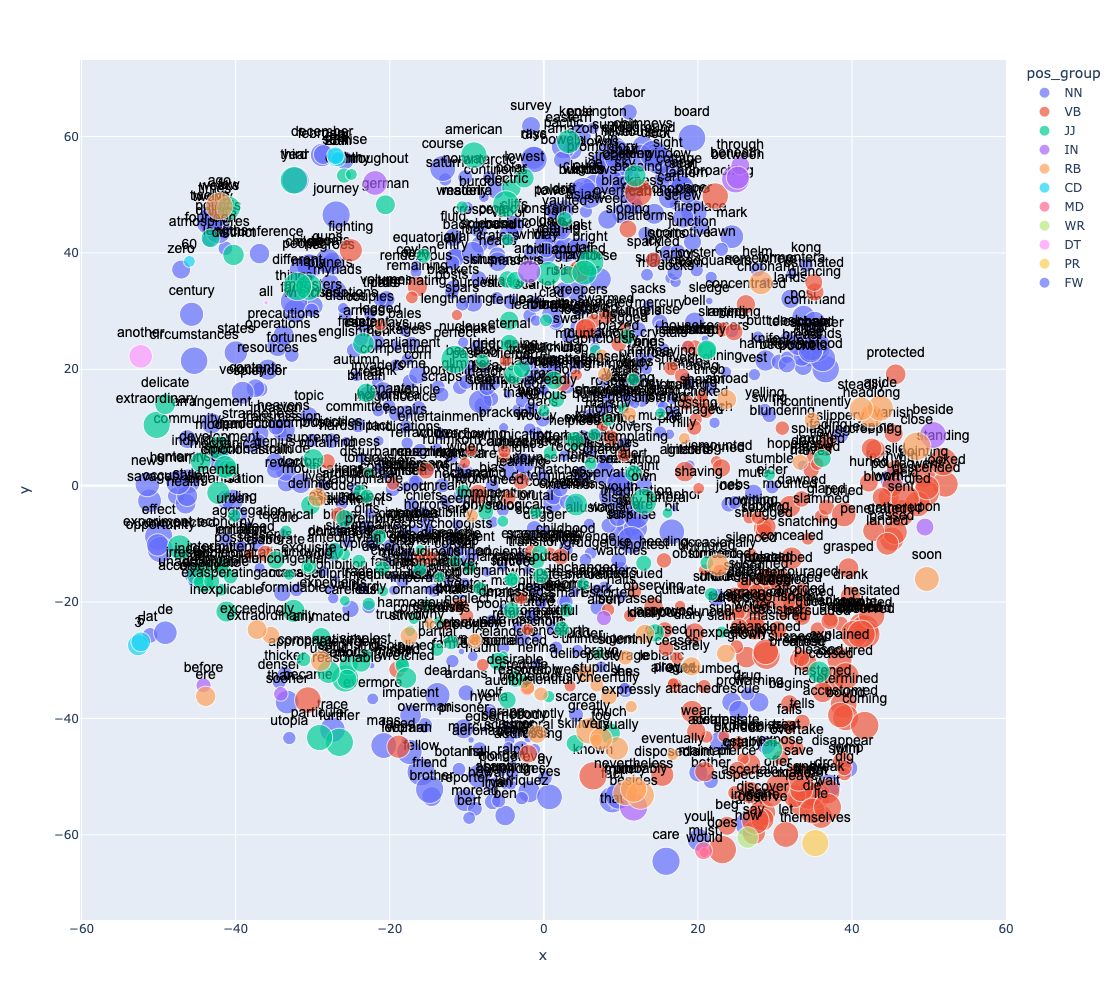

In [26]:
px.scatter(COORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

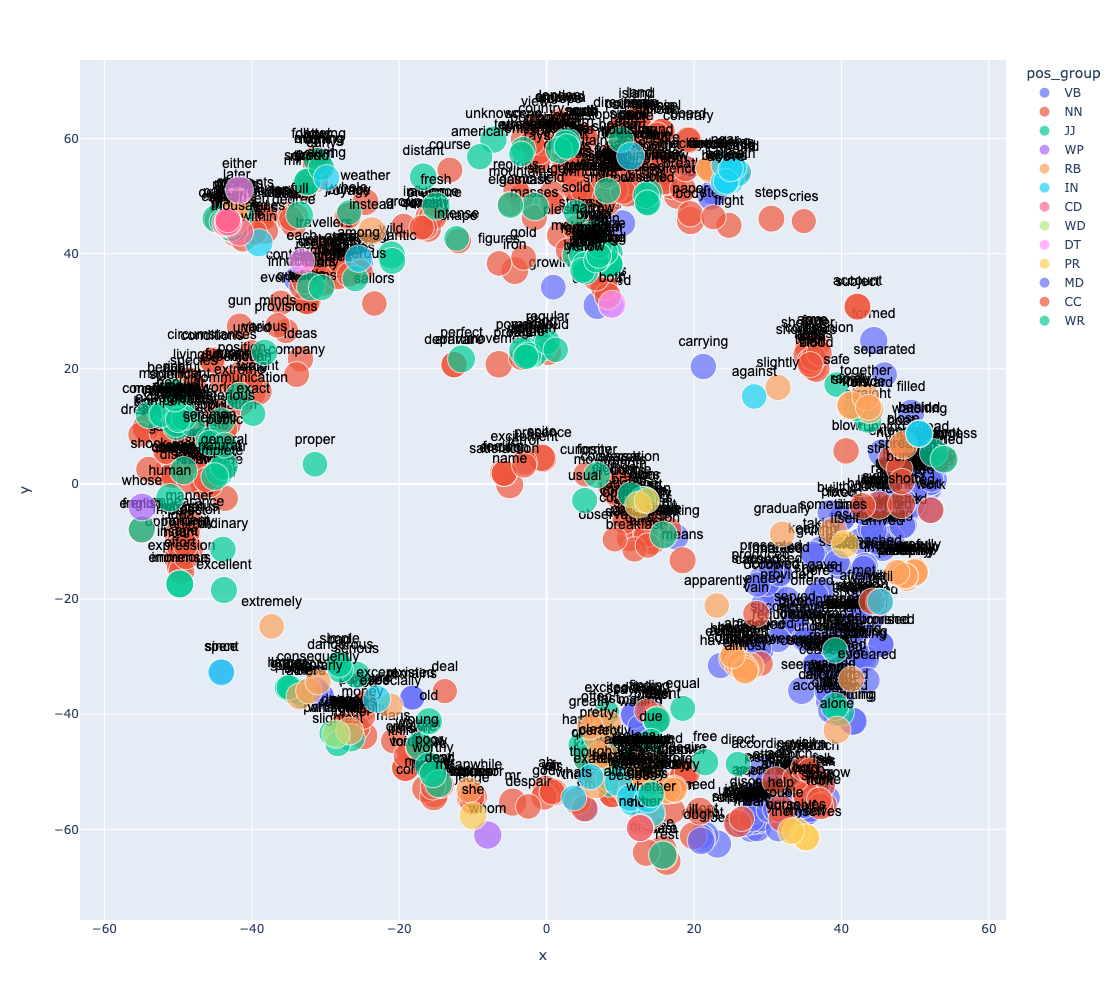

In [27]:
px.scatter(COORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [28]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [29]:
complete_analogy('man', 'boy', 'woman', 3)

term       sim
0  dear  0.773601
1  boys  0.759324
2   yes  0.688536

In [30]:
complete_analogy('girl', 'daughter', 'boy', 3)

term       sim
0       father  0.838054
1       sister  0.800843
2  whereabouts  0.796426

In [31]:
complete_analogy('girl', 'sister', 'boy', 3)

term       sim
0       father  0.826815
1         dear  0.825390
2  whereabouts  0.801861

In [32]:
complete_analogy('man', 'gentleman', 'woman', 5)

term       sim
0      mulatto  0.789887
1        widow  0.772979
2       wretch  0.766596
3          tom  0.751809
4  elphinstone  0.751352

In [33]:
complete_analogy('woman', 'lady', 'man', 5)

term       sim
0  passepartout  0.701870
1           jew  0.681653
2          bert  0.676518
3          hans  0.667672
4          kurt  0.655508

In [34]:
complete_analogy('day', 'sun', 'night', 5)

term       sim
0   horizon  0.738321
1       sky  0.729515
2  twilight  0.725637
3      tide  0.708144
4     waves  0.701187

## Similarites

In [35]:
get_most_similar('joy')

term       sim
0       disgust  0.873075
1  astonishment  0.853875
2          sigh  0.850192
3    perplexity  0.844150
4     amazement  0.840386
5      laughter  0.836722
6        terror  0.836673
7       gesture  0.828255
8      vexation  0.814925
9          rage  0.812431

In [36]:
get_most_similar('man')

term       sim
0        woman  0.749578
1     creature  0.728845
2    invisible  0.716313
3          ape  0.712809
4          dog  0.706983
5     thickset  0.700324
6  unfortunate  0.668751
7      medical  0.664519
8        dying  0.661311
9        young  0.650891

In [37]:
get_most_similar(positive=['man'], negative=['woman'])

term       sim
0         him  0.396268
1      itself  0.364008
2        back  0.343606
3  themselves  0.342421
4        them  0.329331
5         his  0.322433
6     balloon  0.306462
7          he  0.305057
8     himself  0.300711
9        once  0.299658

In [38]:
get_most_similar(positive='woman')

term       sim
0        young  0.843641
1         girl  0.824741
2     creature  0.791456
3       haired  0.780990
4        miner  0.778861
5     thickset  0.769389
6      officer  0.768426
7  unfortunate  0.765964
8        faced  0.765391
9          ape  0.760053

In [39]:
get_most_similar(positive=['woman'], negative=['man'])

term       sim
0         r  0.399229
1         1  0.396715
2         g  0.392299
3         o  0.392118
4         v  0.387743
5         4  0.385934
6         2  0.384050
7         3  0.381670
8         n  0.379610
9  delicate  0.378976

In [40]:
get_most_similar(['man','woman'],['boy','girl'])

term       sim
0     animal  0.406018
1  invisible  0.386198
2     single  0.370420
3       sort  0.360355
4       form  0.348027
5     living  0.334274
6   enormous  0.334181
7        age  0.325555
8    immense  0.322012
9   struggle  0.310389

# Save

In [41]:
W2V.to_csv(f'{data_home}/output/{data_prefix}-W2V.csv')
#VOCAB.to_csv(f'{data_home}/output/{data_prefix}-VOCAB.csv')
SENTS.to_csv(f'{data_home}/output/{data_prefix}-GENSIM_DOCS.csv')

# Experiment: W2V Features as Topics

In [42]:
W2V.describe().T.style.background_gradient(cmap='GnBu')

In [43]:
VSIGS = VOCAB.sort_values('dfidf').tail(1000)

In [44]:
W2Vp = (W2V - W2V.min()) #[0].sort_values().plot()
W2Vp = W2Vp.loc[VSIGS.index]
W2Vp = W2Vp / W2Vp.sum()

In [45]:
# W2Vp[0].sort_values(ascending=False).head(100).plot()

In [46]:
topics = []
for i in W2Vp.columns:
    top_words = ' '.join(W2V.sort_values(i, ascending=False).index[:10])
    print(i, top_words)
    topics.append((i, top_words))

0 barbican master explain discover conseil ned everything land im understand
1 mexico dochart la division training philadelphia revision lucerne toil humboldt
2 stamping negative countenance brain he sorrows self manchetta p frognal
3 flotsam glance last neutral first stage berts reptile effort full
4 dead lay fell alive afloat wherever naked roamed bending am
5 beside down along light toward drove towards behind gave straight
6 itself needs still reveal keep spite penetrate our revealed proportion
7 lower occupy nearest western plateau opposite part hemisphere mongolia heights
8 altogether money force different work having all so apparatus weight
9 a men few one who ages another my three some
10 control series can new over under supply rule republic world
11 got free get getting little coming keep your took iv
12 doing fact manner consequence certain anything exactly knowing discussion case
13 these measure october seas heights january the least winter december
14 should feared should

TypeError: sequence item 9: expected str instance, float found

In [ ]:
# topics

In [ ]:
W2V[4].sort_values().plot()

In [ ]:
W2V.iloc[0].sort_values().reset_index(drop=True).plot()